In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [17]:
# 前処理
df = pd.read_csv('XRP_JPY.csv', encoding='utf-8')
df = df.drop(["始値", "高値", "安値", "出来高", "変化率 %"], axis=1)
df = df.rename(columns={'終値': 'Close', "日付け": 'Date'})
df.set_index("Date", inplace=True)
df = df.sort_index()
df

,Close
Date,
2018-01-23,152.900
2018-01-24,147.820
2018-01-25,146.000
2018-01-26,126.800
2018-01-27,136.104
...,...
2023-11-30,89.793
2023-12-01,90.054
2023-12-02,91.195


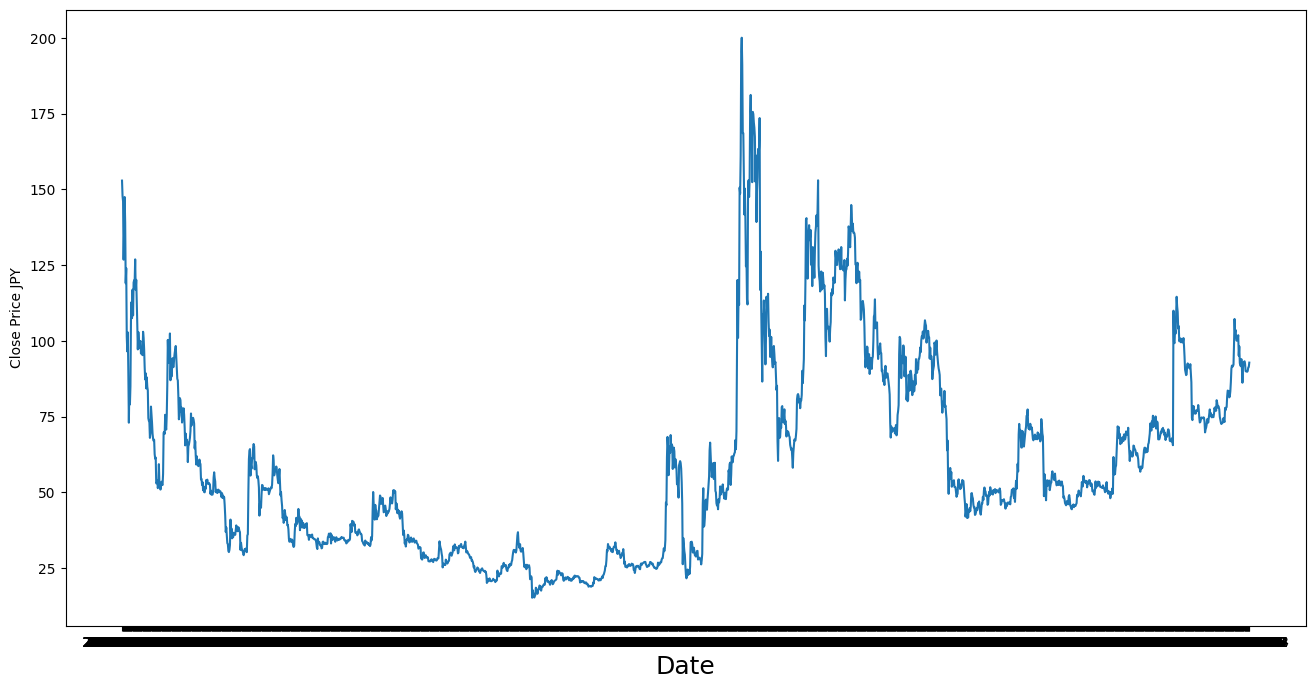

In [15]:
plt.figure(figsize=(16, 8))
plt.plot(df["Close"])
plt.xlabel("Date", fontsize=18)
plt.ylabel("Close Price JPY")
plt.show()

In [ ]:
# 正規化
train = df.loc[]